# MESA Tutorial

From https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html

First the spacial mapping grid from the tutorial. 

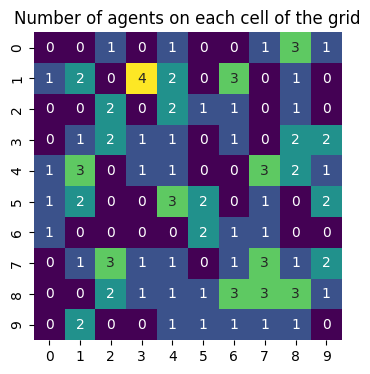

In [2]:
import mesa

# Data visualization tools.
import seaborn as sns

# Has multi-dimensional arrays and matrices. Has a large collection of
# mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        super().__init__()
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, False) # False means no torus
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

# Let’s create a model with 100 agents on a 10x10 grid, and run it for 20 steps.

model = MoneyModel(100, 10, 10)
for i in range(20):
    model.step()

'''  
Now let’s use seaborn and numpy to visualize the number of agents residing in each cell. To do that, we create a numpy array of the same size as the grid, filled with zeros. Then we use the grid object’s coord_iter() feature, which lets us loop over every cell in the grid, giving us each cell’s positions and contents in turn.
'''

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
# Plot using seaborn, with a size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(4, 4)
g.set(title="Number of agents on each cell of the grid");

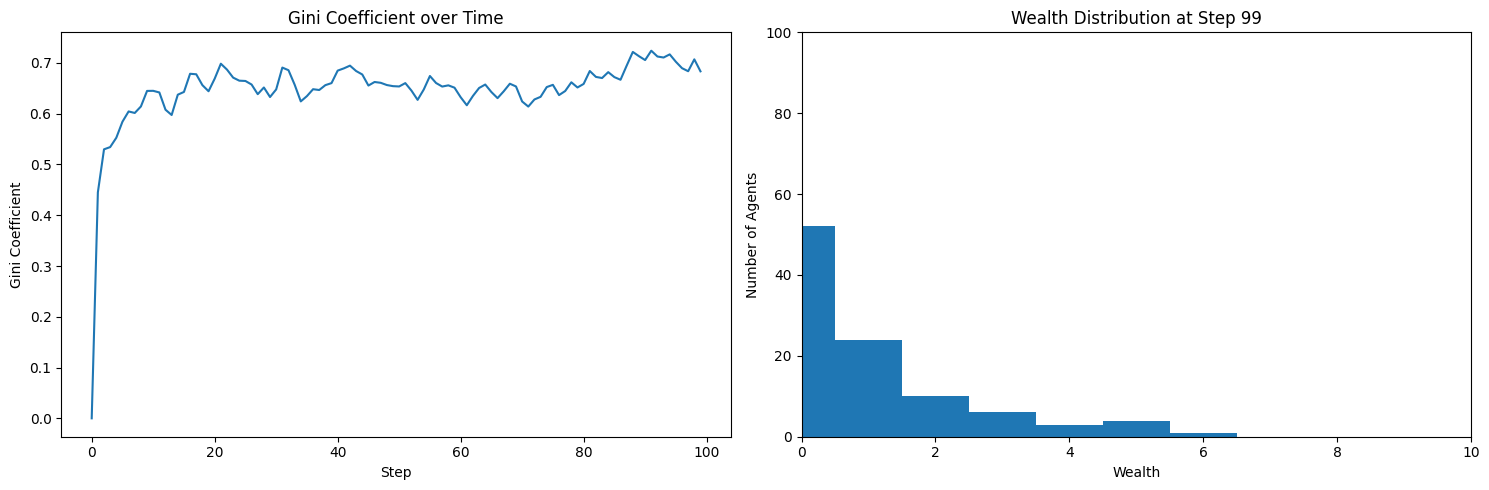

In [2]:
# MESA Tutorial
# From https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
import mesa

# Define the Gini coefficient computation function
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

# Define the MoneyAgent class
class MoneyAgent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            if other != self:
                other.wealth += 1
                self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

# Define the MoneyModel class
class MoneyModel(mesa.Model):
    def __init__(self, N, width, height):
        super().__init__()  # Explicitly call superclass's __init__ method
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

# Initialize the model
model = MoneyModel(100, 10, 10)

# Run the model for a number of steps
for _ in range(100):
    model.step()

# Get the data
gini = model.datacollector.get_model_vars_dataframe()
agent_wealth = model.datacollector.get_agent_vars_dataframe()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Gini coefficient
ax1.plot(gini.index, gini['Gini'])
ax1.set_title('Gini Coefficient over Time')
ax1.set_xlabel('Step')
ax1.set_ylabel('Gini Coefficient')

# Function to update histogram
def update(frame):
    ax2.clear()
    wealth_at_step = agent_wealth.xs(frame, level="Step")["Wealth"]
    ax2.hist(wealth_at_step, bins=range(max(wealth_at_step)+2), align='left')
    ax2.set_title(f'Wealth Distribution at Step {frame}')
    ax2.set_xlabel('Wealth')
    ax2.set_ylabel('Number of Agents')
    ax2.set_ylim(0, model.num_agents)
    ax2.set_xlim(0, 10)  # Set x-axis limit


# Create animation and assign it to a variable
anim = FuncAnimation(fig, update, frames=100, interval=200, repeat=False)

# Save the animation (optional, but helps ensure it's not deleted)
anim.save('money_model_animation.gif', writer='pillow')

plt.tight_layout()
plt.show()


New with fixed axes and bar chart instead of histogram.

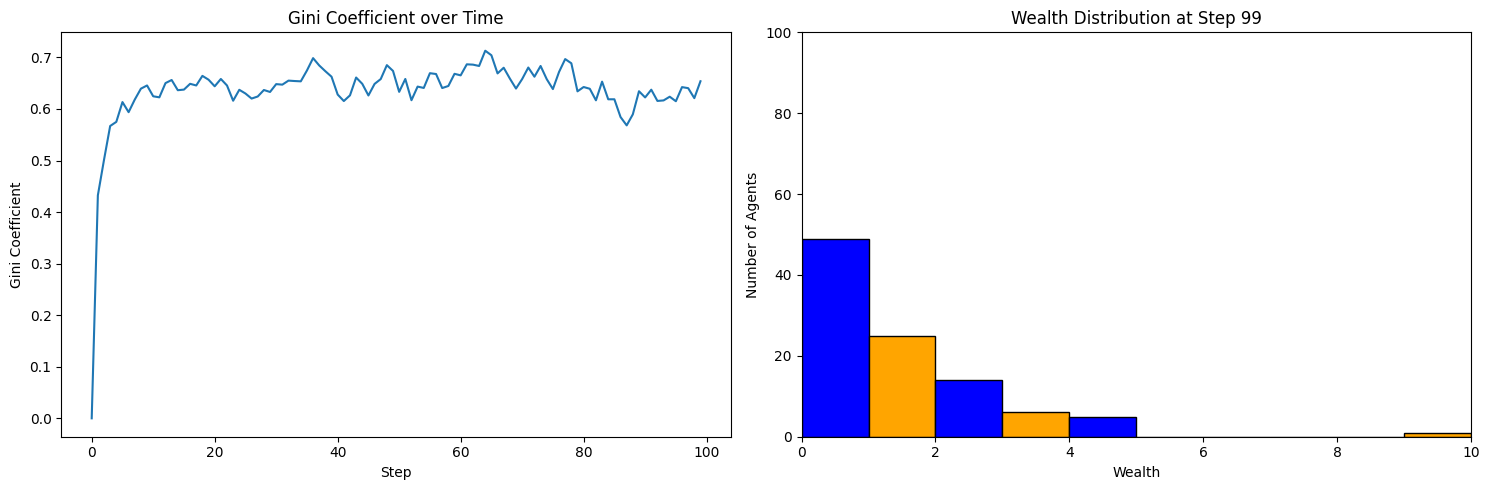

In [3]:
# MESA Tutorial
# From https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
import mesa

# Define the Gini coefficient computation function
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

# Define the MoneyAgent class
class MoneyAgent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            if other != self:
                other.wealth += 1
                self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

# Define the MoneyModel class
class MoneyModel(mesa.Model):
    def __init__(self, N, width, height):
        super().__init__()  # Explicitly call superclass's __init__ method
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

# Initialize the model
model = MoneyModel(100, 10, 10)

# Run the model for a number of steps
for _ in range(100):
    model.step()

# Get the data
gini = model.datacollector.get_model_vars_dataframe()
agent_wealth = model.datacollector.get_agent_vars_dataframe()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Gini coefficient
ax1.plot(gini.index, gini['Gini'])
ax1.set_title('Gini Coefficient over Time')
ax1.set_xlabel('Step')
ax1.set_ylabel('Gini Coefficient')

# Function to update histogram
def update(frame):
    ax2.clear()
    wealth_at_step = agent_wealth.xs(frame, level="Step")["Wealth"]
    counts, bins = np.histogram(wealth_at_step, bins=range(max(wealth_at_step)+2))
    colors = ['blue' if i % 2 == 0 else 'orange' for i in range(len(counts))]
    ax2.bar(bins[:-1], counts, width=1, align='edge', color=colors, edgecolor='black')
    ax2.set_title(f'Wealth Distribution at Step {frame}')
    ax2.set_xlabel('Wealth')
    ax2.set_ylabel('Number of Agents')
    ax2.set_ylim(0, model.num_agents)
    ax2.set_xlim(0, 10)  # Set x-axis limit

# Create animation and assign it to a variable
anim = FuncAnimation(fig, update, frames=100, interval=200, repeat=False)

# Save the animation (optional, but helps ensure it's not deleted)
anim.save('money_model_animation.gif', writer='pillow')

plt.tight_layout()
plt.show()

Try and make an arbitrary shaped room. Use SingleGrid to enforce one agent per space. We will create "people" who want to have at least one space between them and their neighbours. We can also create "walls" that are impassable, and "doors" that are passable, "bars" that are desirable, and "stage" that is the goal but are impassable. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
import mesa

